# Clustering categorical variables

Besides the EDA's by categories performed previously, we are going to add a depth analysis using Machine Learning techniques for unsupervised models. As we saw earlier, the results from chi-squared statitical tests revealed a list of 20 potential interesting variables related to the anxiety and depression disorders in the surveyed population. Now, we are coming back to the universal variables trying to find clusters of our datapoints. Unfortunately, PCA, the classic dimensionality reduction tool, is useless in the context of categorical variables. 

## Part 1: Dimensionality reduction and clustering of surveyed people

"In many cases, available measurements are not numerical but qualitative or categorical. The corresponding data variables represent categories—nonnumeric quantities, e.g., phenotypes, cohort memberships, sample sequencing runs, survey respondent ratings. When the relationship between the levels (distinct values) of two categorical variables is of interest, CA is applied to a contingency table (constructed from the data) whose entries are the categories' co-occurrence frequencies. If more than two categorical variables are available, MCA enables the study of both the relationship between the observations and the associations between variable categories. MCA is a generalization of CA and is simply CA applied to an indicator matrix formed by a dummy (one-hot) encoding of the categorical variables [5]. When the input data contain both numerical and categorical variables, two strategies are available. If only a few categorical variables are present, PCA is used on numerical variables, and the group means for the levels of the categorical variables can be projected as supplementary (unweighted) points (see chapter 9 of [1] for details). On the other hand, if the mixed dataset contains a large number of categorical variables, multiple factor analysis (MFA) [31] can be used. The method applies PCA on numerical and MCA on categorical variables and combines the results by weighing variable groups" *[Ten quick tips for effective dimensionality reduction](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006907)*. 

In this section, we perform dimensionality reduction using MCA and MFA.

Factor Analysis is used to find out the uniqueness among many attributes (variables). A lot of attributes exist in large Dataset. Some attributes/records are meaningless for the purpose of analysis. So observed attributes (variables) are selected with many traditional analysis techniques but these techniques do not perform well at some extent. To remove this bottleneck, Factor Analysis approach is used that finds meaningful observed attributes (variables) in large.

MCA is best used to analyze a categorical multivariate data matrix when you are willing to make no stronger assumption that all variables are analyzed at the nominal level. Also, MCA will be most successful when the variables are homogeneous. Variables are considered homogeneous when they classify objects in the same categories into the same subgroups. 

## Part 2: Analysis by state, Dendrograms and clustering

In [1]:
import pandas as pd
import numpy as np
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
import sys
#!{sys.executable} -m pip install kmodes
#!{sys.executable} -m pip install --user prince
from kmodes.kmodes import KModes
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import fcluster
import prince #MCA

## 1. Read the dataset, delete the contextual variables and apply the same preprocessing steps used for the chi-squared statistical tests for feature selection.

In [3]:
df_pulse = pd.read_csv('../data/interim/pulse2020_puf_all.csv')

In [4]:
df_pulse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197365 entries, 0 to 1197364
Columns: 207 entries, SCRAM to depression_disorder
dtypes: bool(2), float64(203), object(2)
memory usage: 1.8+ GB


In [5]:
secondary_columns = [
                    'KINDWORK',
                    'RSNNOWRK',
                    'UNEMPPAY',
                    'FOODSUFRSN1',
                    'FOODSUFRSN2',
                    'FOODSUFRSN3',
                    'FOODSUFRSN4',
                    'FOODSUFRSN5',
                    'WHEREFREE1',
                    'WHEREFREE2',
                    'WHEREFREE3',
                    'WHEREFREE4',
                    'WHEREFREE5',
                    'WHEREFREE6',
                    'WHEREFREE7',
                    'FOODCONF',
                    'MORTLMTH',
                    'MORTCONF',
                    'TEACH1',
                    'TEACH2',
                    'TEACH3',
                    'TEACH4',
                    'TEACH5',
                    'COMPAVAIL',
                    'COMP1',
                    'COMP2',
                    'COMP3',
                    'INTRNTAVAIL',
                    'INTRNT1',
                    'INTRNT2',
                    'INTRNT3',
                    'TSCHLHRS',
                    'TTCH_HRS'
                    ]

In [6]:
print('Number of contextual variables: {}'.format(len(secondary_columns)))

Number of contextual variables: 33


Deleting contextual variables

In [7]:
df_universal = df_pulse.drop(columns=secondary_columns)

As we use `anxiety_disorder` and `depression_disorder` variables, the use of `ANXIOUS`, `INTEREST`, `DOWN` and `WORRY` is redundant.

Drop columns when they have lost up to 50% of information (testing different thresholds)

In [8]:
threshold = int(0.5*len(df_universal))
threshold

598682

In [9]:
df_universal1 = df_universal.dropna(axis=1, thresh=threshold)

Drop id surveyed (SCRAM), WEEK, and variables `ANXIOUS`, `WORRY` (used to estimate the ANXIETY DISORDER) and `DOWN`, `INTEREST` (used to score DEPRESSION DISORDER).

In [10]:
df_universal1.drop(columns=['SCRAM', 'WEEK', 'ANXIOUS', 'WORRY', 'DOWN', 'INTEREST'], inplace=True)

Drop duplicates and missing datapoints

In [11]:
df_universal1.drop_duplicates(inplace=True) #The techniques below explote with missing data!

In [12]:
df_universal1.shape

(1197252, 41)

In [13]:
df_universal1.dropna(inplace=True)

In [14]:
# y = df_universal1.anxiety_disorder

# for col in df_universal1.columns:
#     if col not in list_variables:
#         df_universal1.drop(columns=col, inplace=True)

In [15]:
df_universal1.head()

EST_ST      PWEIGHT  ABIRTH_YEAR  EGENDER  AGENDER  RHISPANIC  AHISPANIC  \
0    47.0  1973.489532          2.0      2.0      2.0        1.0        2.0   
2    26.0  1526.612380          2.0      2.0      2.0        1.0        2.0   
3     1.0  2734.635354          2.0      1.0      2.0        1.0        2.0   
4     1.0   681.211425          2.0      2.0      2.0        1.0        2.0   
6     1.0  1647.093908          2.0      2.0      2.0        1.0        2.0   

   RRACE  ARACE  EEDUC  ...  HLTHINS6  HLTHINS7  HLTHINS8  DELAY  NOTGET  \
0    1.0    2.0    6.0  ...       2.0       2.0       2.0    2.0     2.0   
2    4.0    2.0    6.0  ...       2.0       2.0       2.0    1.0     1.0   
3    1.0    2.0    4.0  ...       2.0       2.0       1.0    1.0     1.0   
4    1.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   
6    2.0    2.0    7.0  ...       2.0       2.0       2.0    2.0     2.0   

   TENURE  INCOME   AGE  anxiety_disorder  depression_disorder  
0     3.0     4.0  34.0              True                False  
2     2.0     8.0  44.0             False                False  
3     2.0     1.0  56.0              True                 True  
4     2.0     4.0  57.0             False                False  
6     3.0     4.0  37.0             False                False  

[5 rows x 41 columns]

Sampling data (the advantage of PCA is that it's computationally cheap related to other techniques. To avoid explosions, we use a sample of the dataset).

In [16]:
Xsample = df_universal1.sample(10000, random_state=42)

## 2. MCA Dimensionality Reduction

This technique consider only categorical variables. One of our variables is numerical (weight of the surveyed people). To perform the following technique, we ignore this column and all the variables are converted in categorical (both ordinal and nominal variables are represented by float and int types until now)

In [17]:
Xsample.columns

Index(['EST_ST', 'PWEIGHT', 'ABIRTH_YEAR', 'EGENDER', 'AGENDER', 'RHISPANIC',
       'AHISPANIC', 'RRACE', 'ARACE', 'EEDUC', 'AEDUC', 'MS', 'THHLD_NUMPER',
       'AHHLD_NUMPER', 'THHLD_NUMKID', 'AHHLD_NUMKID', 'THHLD_NUMADLT',
       'WRKLOSS', 'EXPCTLOSS', 'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF',
       'FREEFOOD', 'TSPNDFOOD', 'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1',
       'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7',
       'HLTHINS8', 'DELAY', 'NOTGET', 'TENURE', 'INCOME', 'AGE',
       'anxiety_disorder', 'depression_disorder'],
      dtype='object')

In [18]:
X_cat = Xsample.drop(columns=['PWEIGHT', 'AGE']) #delete the continuous variables
df=X_cat.copy()

for var in df.columns:
    df[var]=df[var].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 647190 to 388738
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   EST_ST               10000 non-null  category
 1   ABIRTH_YEAR          10000 non-null  category
 2   EGENDER              10000 non-null  category
 3   AGENDER              10000 non-null  category
 4   RHISPANIC            10000 non-null  category
 5   AHISPANIC            10000 non-null  category
 6   RRACE                10000 non-null  category
 7   ARACE                10000 non-null  category
 8   EEDUC                10000 non-null  category
 9   AEDUC                10000 non-null  category
 10  MS                   10000 non-null  category
 11  THHLD_NUMPER         10000 non-null  category
 12  AHHLD_NUMPER         10000 non-null  category
 13  THHLD_NUMKID         10000 non-null  category
 14  AHHLD_NUMKID         10000 non-null  category
 15  THHLD_NUMADLT

In [20]:
mca = prince.MCA()
mca = mca.fit(df) # same as calling ca.fs_r(1)
mca = mca.transform(df) # same as calling ca.fs_r_sup(df_new) for *another* test set.
print(mca)

               0         1
647190 -0.255553  0.310624
903223  0.424598  0.372335
307994 -0.271427 -0.232663
25255   0.483189 -0.024400
242352 -0.309305  0.359084
...          ...       ...
736174  0.414448 -0.357110
885451 -0.418487 -0.337108
624172 -0.142236 -0.337370
791830  0.018462  0.379694
388738  0.638200 -0.460687

[10000 rows x 2 columns]


## 3. Multi Factor Analysis Dimensionality Reduction

In this case, MFA allows the use of numerical and categorical variables. 

In [21]:
df1=Xsample.copy()

for var in df1.columns:
    if var not in ['PWEIGHT', 'AGE']:
        df1[var]=df1[var].astype('category')

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 647190 to 388738
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   EST_ST               10000 non-null  category
 1   PWEIGHT              10000 non-null  float64 
 2   ABIRTH_YEAR          10000 non-null  category
 3   EGENDER              10000 non-null  category
 4   AGENDER              10000 non-null  category
 5   RHISPANIC            10000 non-null  category
 6   AHISPANIC            10000 non-null  category
 7   RRACE                10000 non-null  category
 8   ARACE                10000 non-null  category
 9   EEDUC                10000 non-null  category
 10  AEDUC                10000 non-null  category
 11  MS                   10000 non-null  category
 12  THHLD_NUMPER         10000 non-null  category
 13  AHHLD_NUMPER         10000 non-null  category
 14  THHLD_NUMKID         10000 non-null  category
 15  AHHLD_NUMKID 

In [23]:
mfa = FactorAnalysis(n_components=5, random_state=0)
mfa = mfa.fit_transform(Xsample)
mfa.shape

(10000, 5)

## 4. Clustering

Finding the appropiate number of clusters through **Silhouette Score**:

In [24]:
# define the k-modes model and iterate using different number of clusters
clusters_list = [2, 4, 6]
silhouette_avg_list = []

for k in clusters_list:
    km = KModes(n_clusters=k, init='Huang', n_init=11, verbose=0)
    # fit the clusters to the skills dataframe
    clusters = km.fit_predict(Xsample)
    #compute the silhouette score
    silhouette_avg = silhouette_score(Xsample, clusters)
    silhouette_avg_list.append(silhouette_avg)

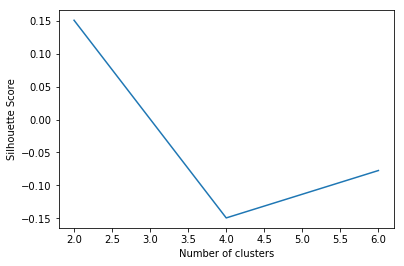

In [25]:
_ = plt.plot(clusters_list, silhouette_avg_list)
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('Silhouette Score')

It seems like the unique option is the use of 2 clusters. Calculating centroids and labels for K=2,

In [26]:
k=2
km = KModes(n_clusters=k, init='Huang', n_init=11, verbose=0)
# fit the clusters to the skills dataframe
clusters = km.fit_predict(Xsample)
# get an array of cluster modes
kmodes = km.cluster_centroids_
shape = kmodes.shape

In [27]:
clusters

array([1, 0, 1, ..., 1, 1, 0], dtype=uint16)

## 5. Clustering and Dimensionality Reduction

### 5.1 kModes and MCA

#### 5.1.1 Anxiety dimensional space projection

In [28]:
Xsample1 = Xsample.replace({'EGENDER': {1.0: 'Man', 2.0: 'Woman'},
                'TENURE': {1.0: 'Owned', 2.0: 'Owned+loan', 3.0: 'Rented', 4.0:'Occupied no payment'},
                'NOTGET': {1.0: 'Yes', 2.0: 'No'},
                'DELAY': {1.0: 'Yes', 2.0: 'No'},
                'CURFOODSUF': {1.0: 'Enough they want to eat', 2.0: 'Enough, not always they want to eat', 3.0: 'Sometimes not enough', 4.0: 'Often not enough'},
                'HLTHSTATUS': {1.0: 'Excellent', 2.0: 'Very good', 3.0: 'Good', 4.0: 'Fair', 5.0: 'Poor'},
                'RRACE': {1.0: 'White', 2.0: 'Black', 3.0: 'Asian', 4.0: 'Other'}})

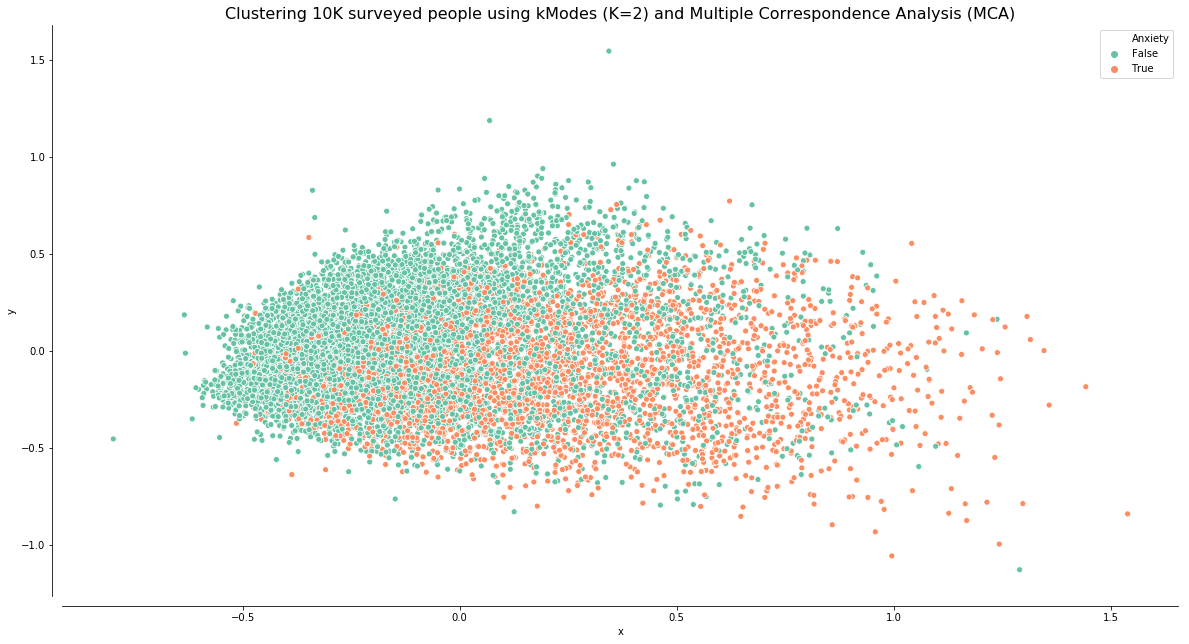

In [29]:
df_mca = pd.DataFrame({'id': Xsample1.index,
                       'Anxiety': Xsample1.anxiety_disorder,
                       'Depression': Xsample1.anxiety_disorder,
                       'Gender': Xsample1.EGENDER,
                       'Income': Xsample1.INCOME,
                       'Tenure': Xsample1.TENURE,
                       'Not_get': Xsample1.NOTGET,
                       'Delay': Xsample1.DELAY,
                       'Health_status': Xsample1.HLTHSTATUS,
                       'Food_sufficiency': Xsample1.CURFOODSUF,
                       'Race': Xsample1.RRACE,
                       'cluster_id': clusters, 
                       'x': mca[0], 
                       'y': mca[1]})

df_mca.loc[df_mca.cluster_id == 0, 'category'] = 'A'
df_mca.loc[df_mca.cluster_id == 1, 'category'] = 'B'

f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Anxiety',
                    data=df_mca, palette='Set2')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.2 Depression dimensional space projection

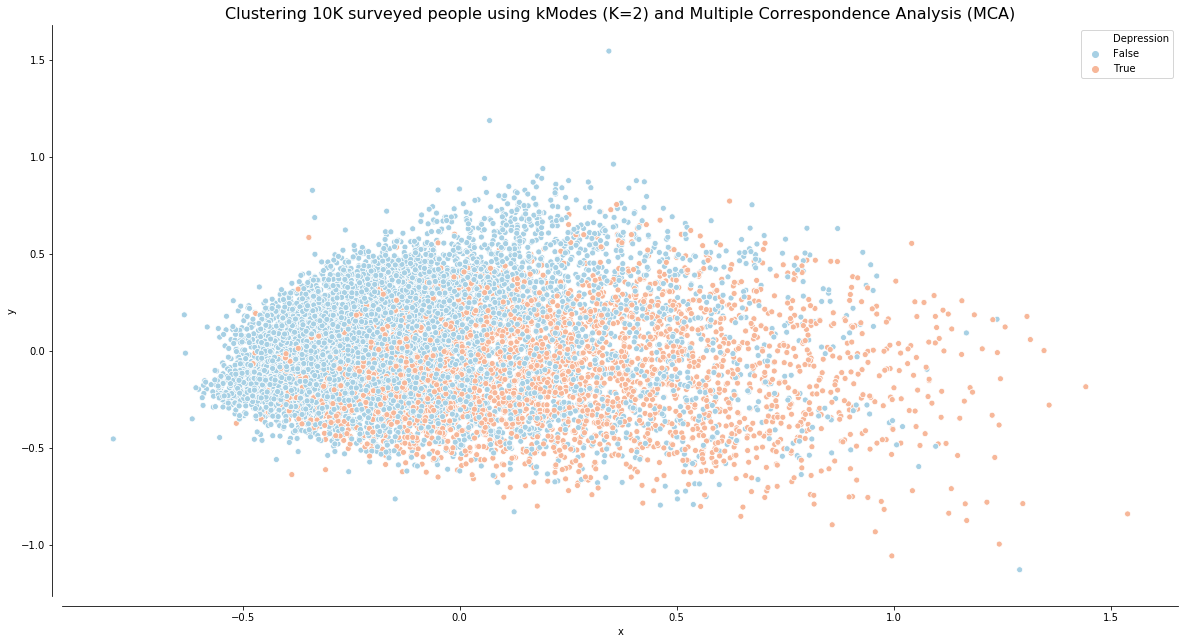

In [30]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', hue='Depression',
                    data=df_mca, palette='RdBu_r')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.3 Dimensional relationships: Anxiety and Income

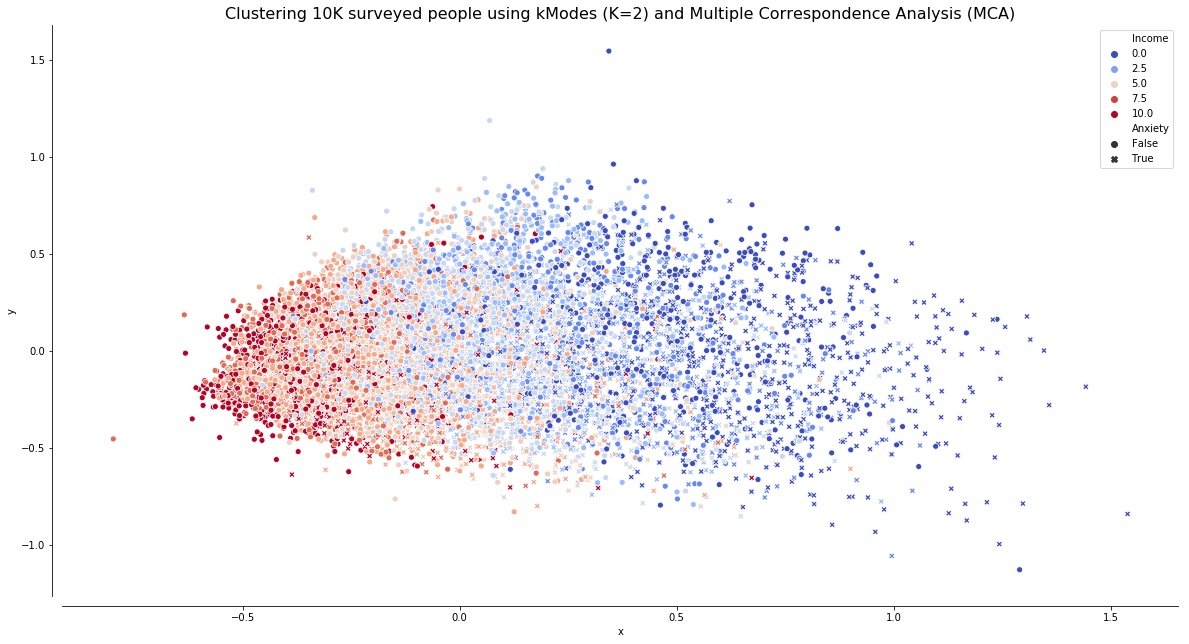

In [31]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Income',
                    data=df_mca, palette='coolwarm')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.4 Dimensional relationships: Anxiety and Gender

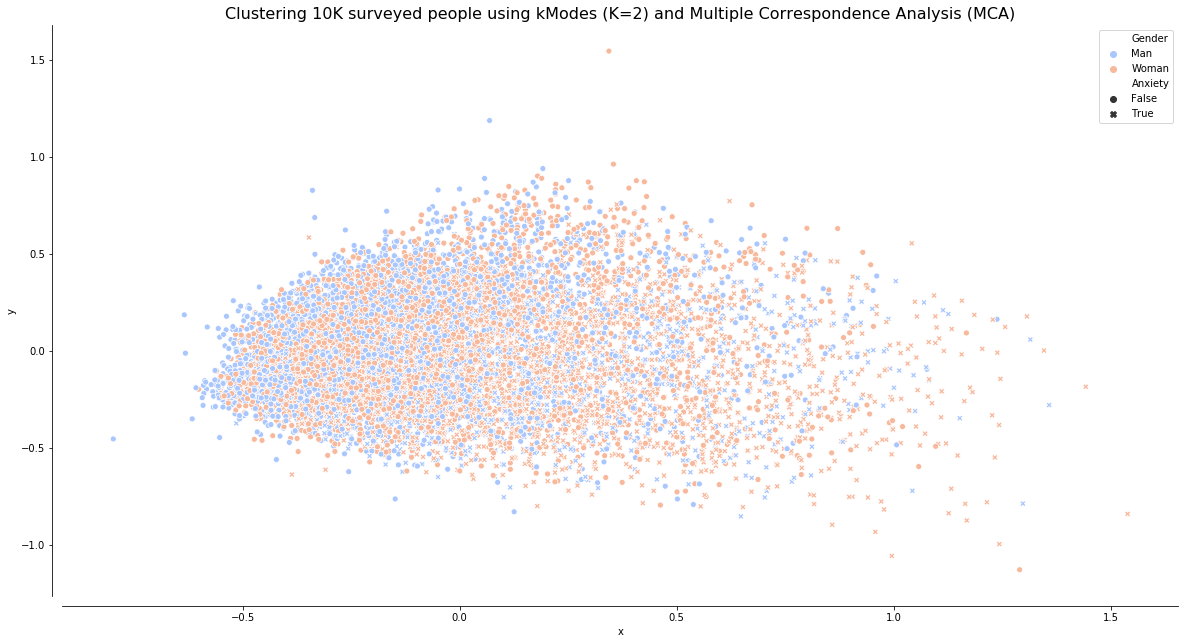

In [32]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Gender',
                    data=df_mca, palette='coolwarm')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.5 Dimensional relationships: Anxiety and House security

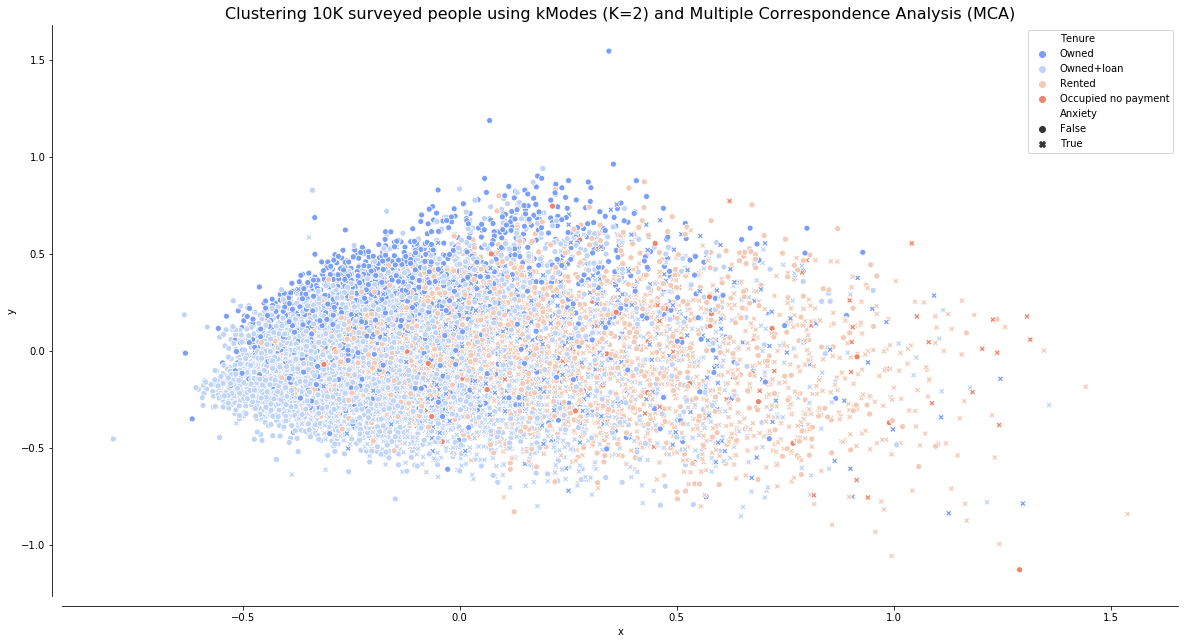

In [33]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Tenure',
                    data=df_mca, palette='coolwarm')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.6 Dimensional relationships: Anxiety and Delayed medical care (not related to pandemic)

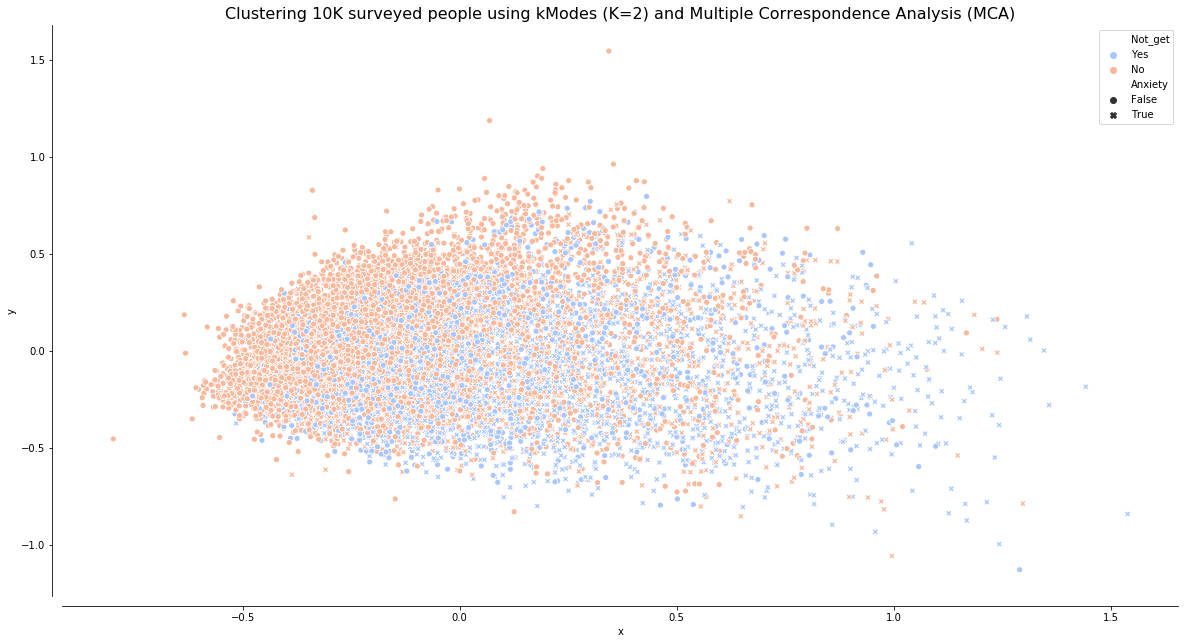

In [34]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Not_get',
                    data=df_mca, palette='coolwarm')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.7 Dimensional relationships: Anxiety and Delayed medical care due to pandemic

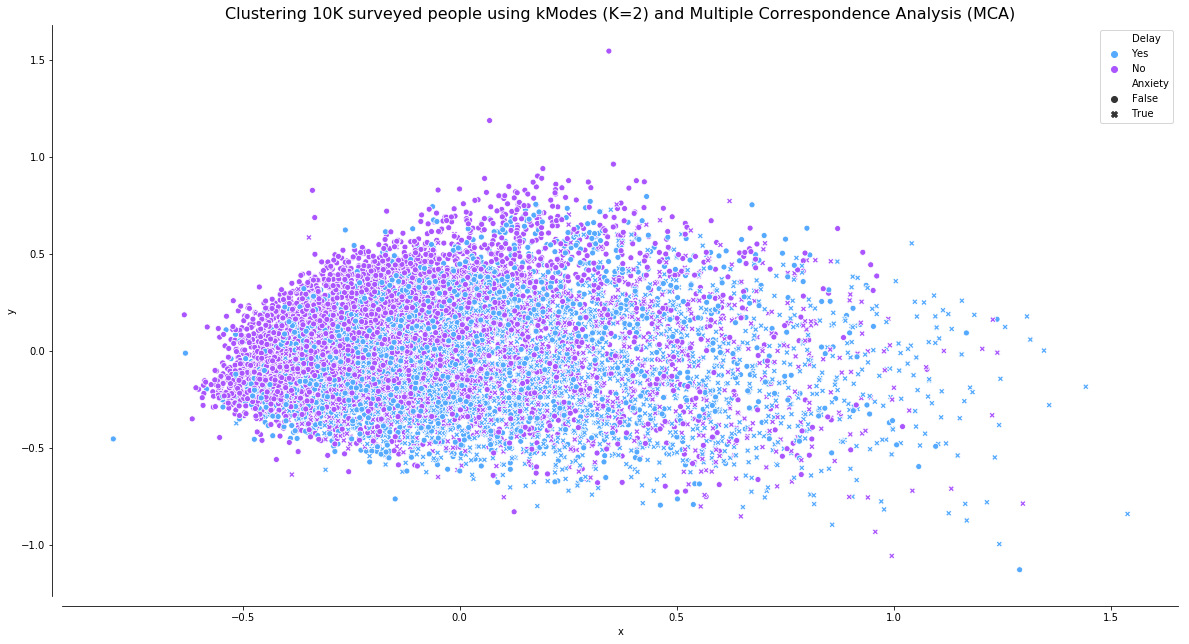

In [35]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Delay',
                    data=df_mca, palette='cool')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.8 Dimensional relationships: Anxiety and Food sufficiency

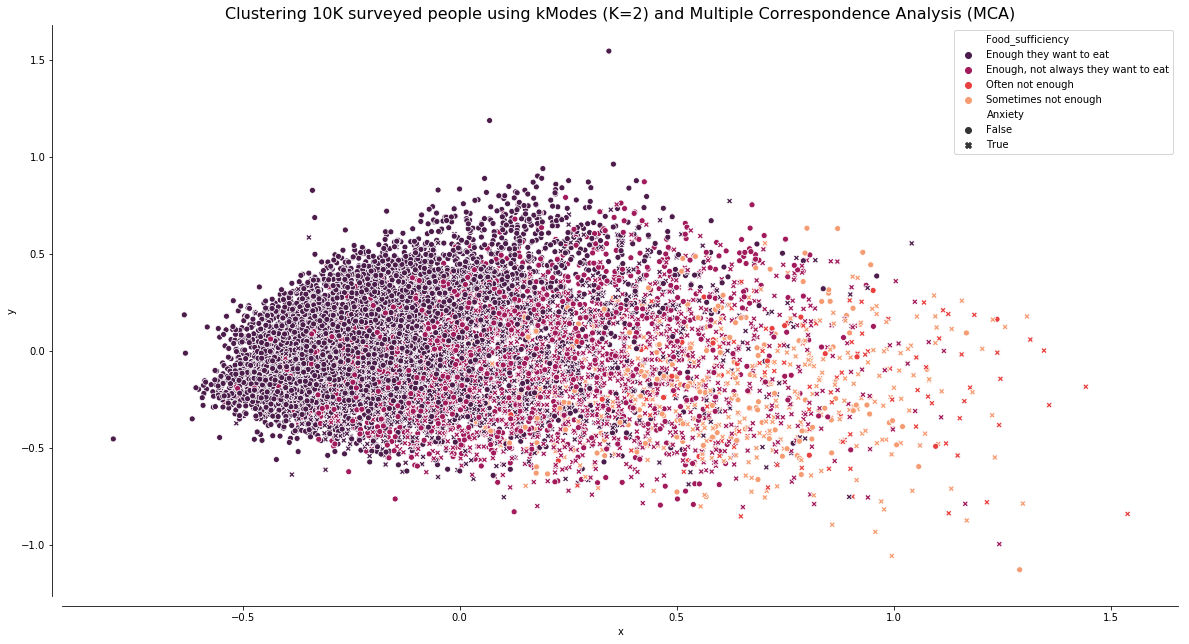

In [36]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Food_sufficiency',
                    data=df_mca, palette='rocket')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.9 Dimensional relationships: Anxiety and Health Status

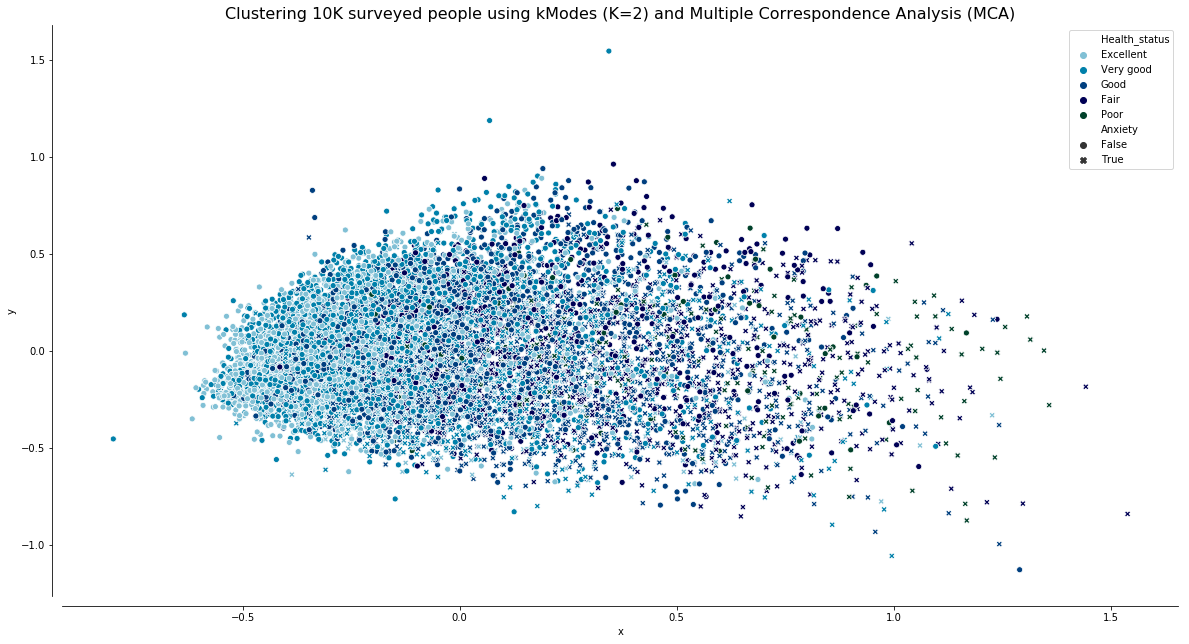

In [37]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Health_status', hue_order= ["Excellent", "Very good", 'Good', "Fair", "Poor"],
                    data=df_mca, palette='ocean_r')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

#### 5.1.10 Dimensional relationships: Anxiety and Race

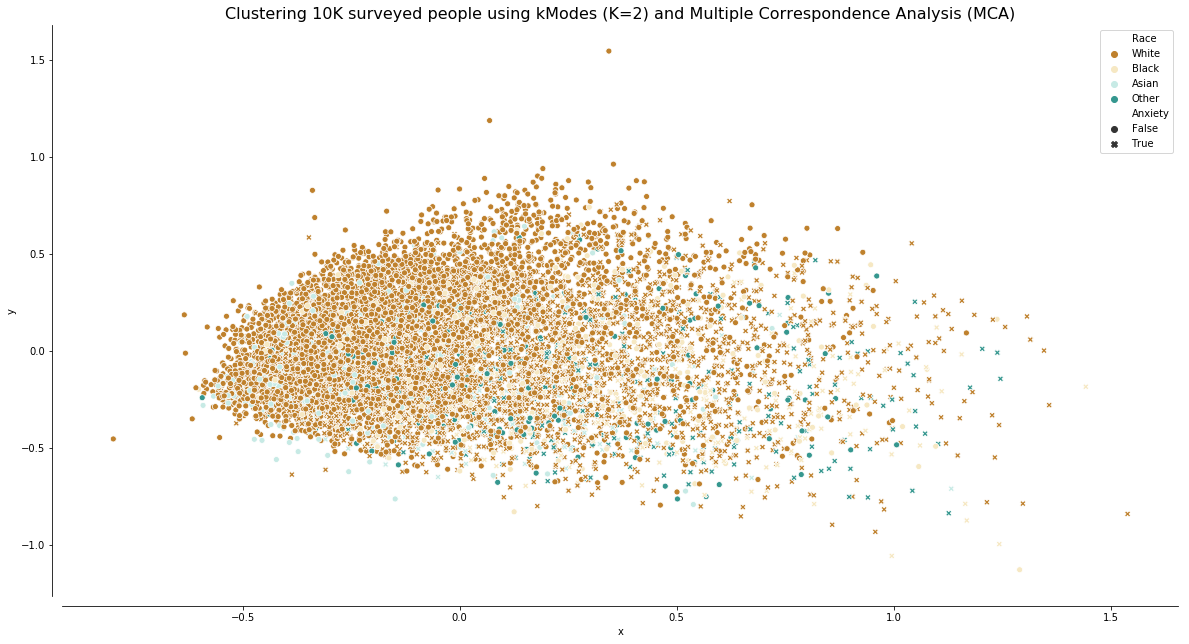

In [38]:
f, ax = plt.subplots(figsize=(20, 10.5))
#_ = sns.despine(f, left=True, bottom=True)
_ = sns.despine(f, offset=10);
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Race',
                    data=df_mca, palette='BrBG')
_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Correspondence Analysis (MCA)', size=16)
_ = plt.show()

### 5.2 kModes and MFA

In [39]:
df_mfa = pd.DataFrame({'id': Xsample1.index,
                       'Anxiety': Xsample1.anxiety_disorder,
                       'Depression': Xsample1.anxiety_disorder,
                       'Gender': Xsample1.EGENDER,
                       'Income': Xsample1.INCOME,
                       'Tenure': Xsample1.TENURE,
                       'Not_get': Xsample1.NOTGET,
                       'Delay': Xsample1.DELAY,
                       'Health_status': Xsample1.HLTHSTATUS,
                       'Food_sufficiency': Xsample1.CURFOODSUF,
                       'Race': Xsample1.RRACE,
                       'cluster_id': clusters, 
                       'x': mfa[:, 0], 
                       'y': mfa[:, 4]})

df_mfa.loc[df_mfa.cluster_id == 0, 'category'] = 'A'
df_mfa.loc[df_mfa.cluster_id == 1, 'category'] = 'B'


#### 5.2.1 Anxiety dimensional space projection

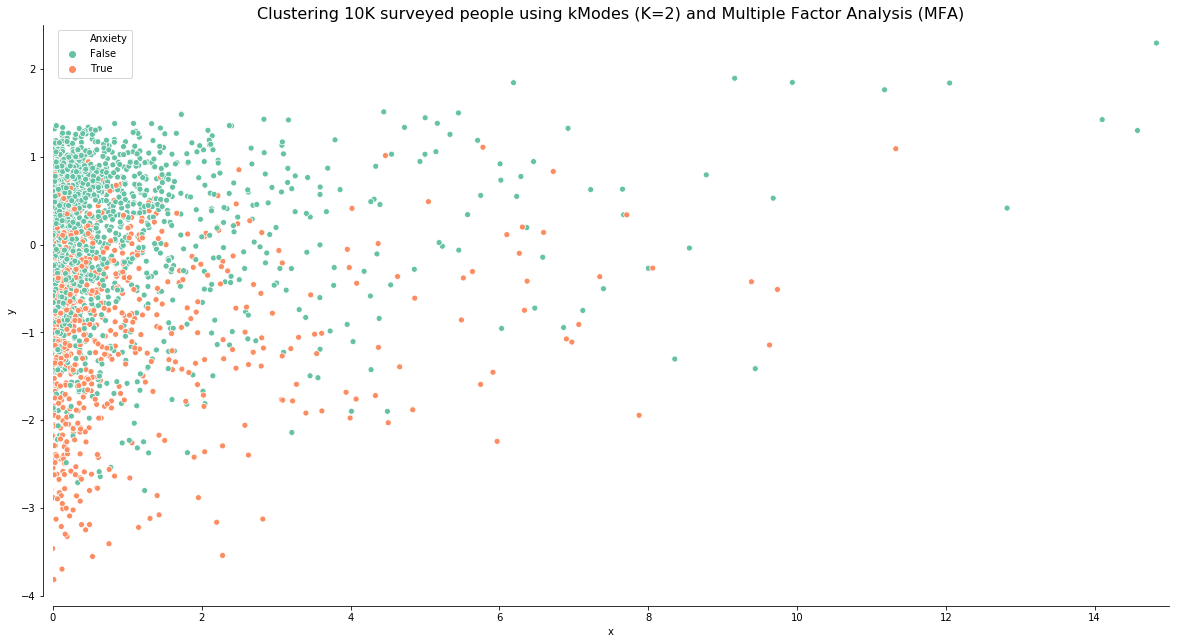

In [40]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', hue='Anxiety',
                    data=df_mfa, palette='Set2')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.2 Depression dimensional space projection

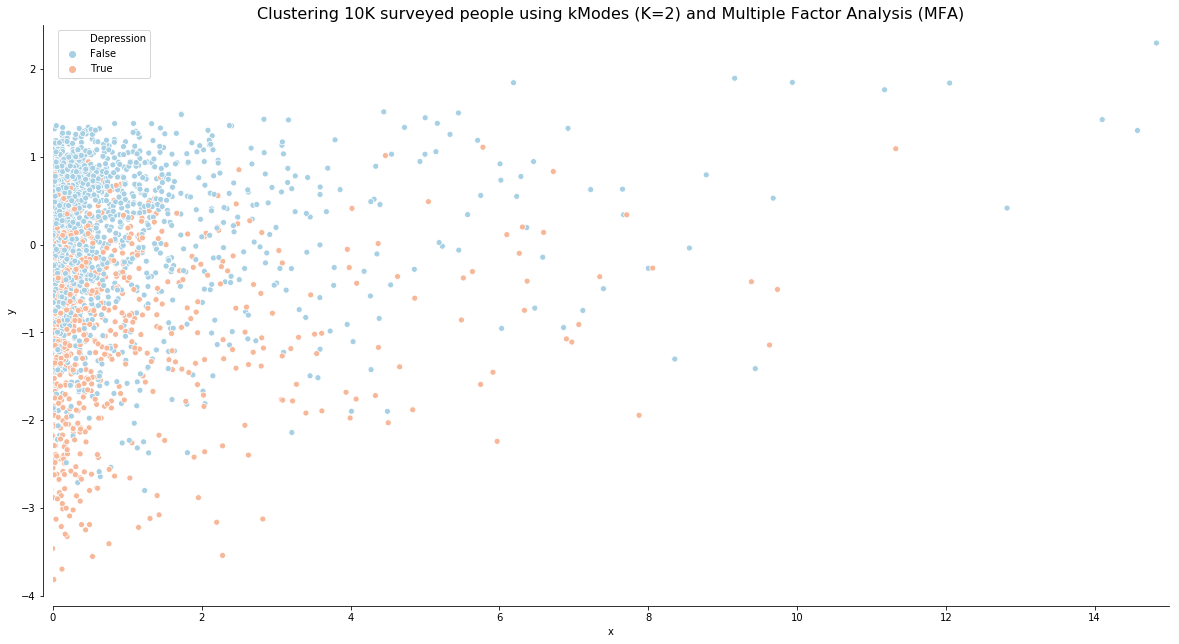

In [41]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', hue='Depression',
                    data=df_mfa, palette='RdBu_r')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.3 Dimensional relationships: Anxiety and Income

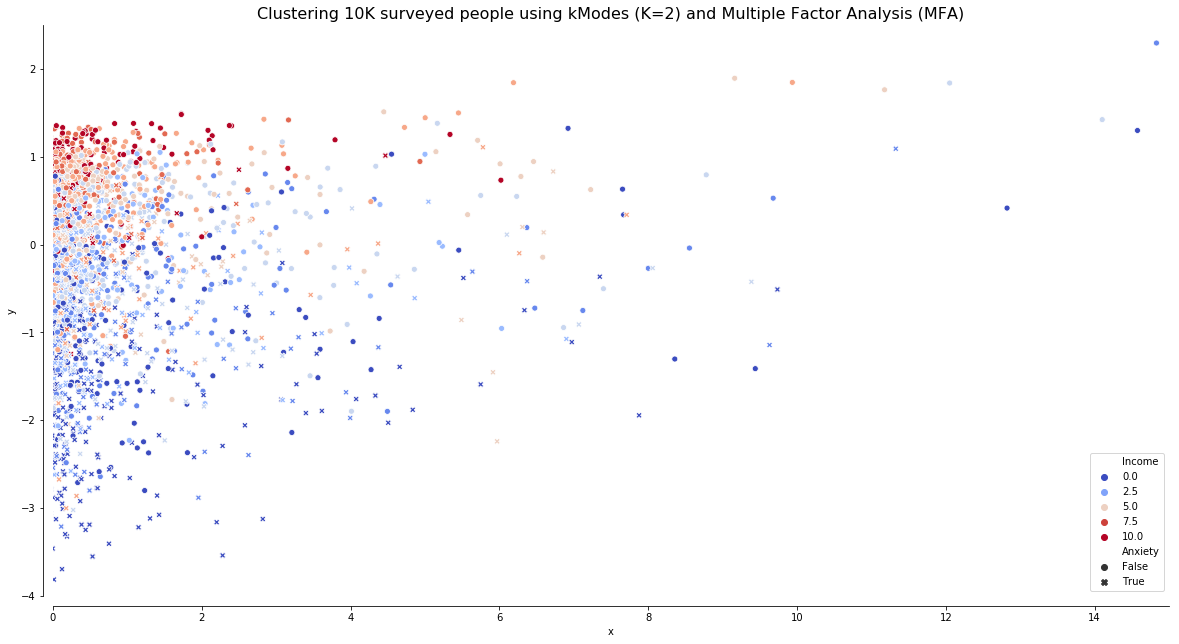

In [42]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Income',
                    data=df_mfa, palette='coolwarm')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.4 Dimensional relationships: Anxiety and Gender

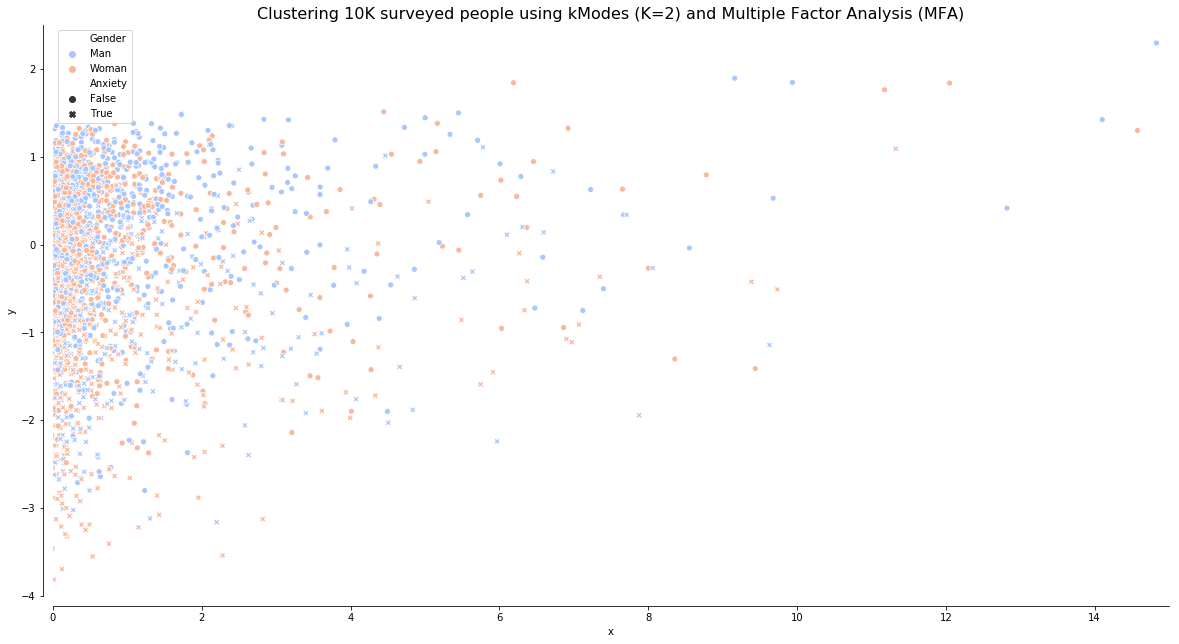

In [43]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Gender',
                    data=df_mfa, palette='coolwarm')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.5 Dimensional relationships: Anxiety and House security

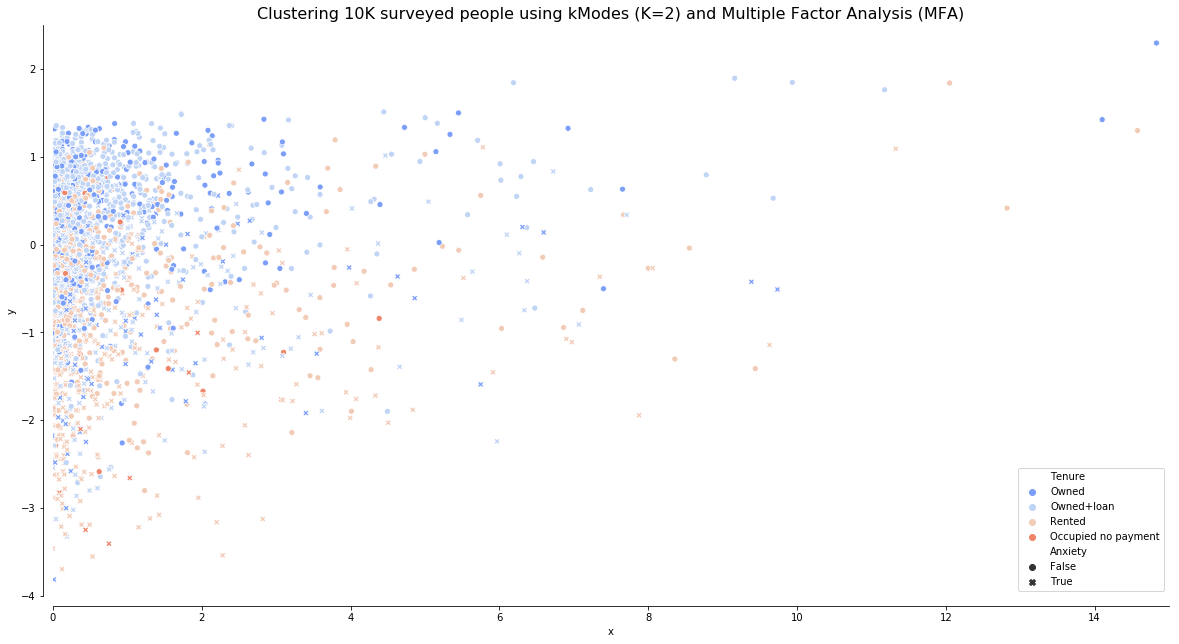

In [44]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Tenure',
                    data=df_mfa, palette='coolwarm')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.6 Dimensional relationships: Anxiety and Delayed medical care (not related to pandemic)

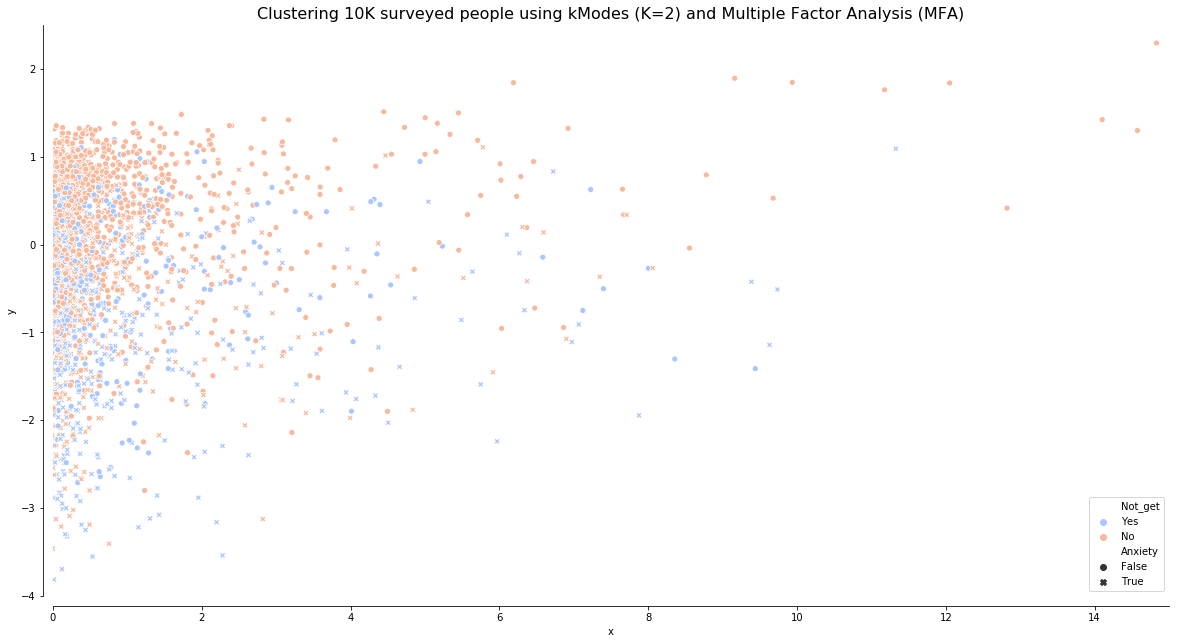

In [45]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Not_get',
                    data=df_mfa, palette='coolwarm')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.7 Dimensional relationships: Anxiety and Delayed medical care due to pandemic

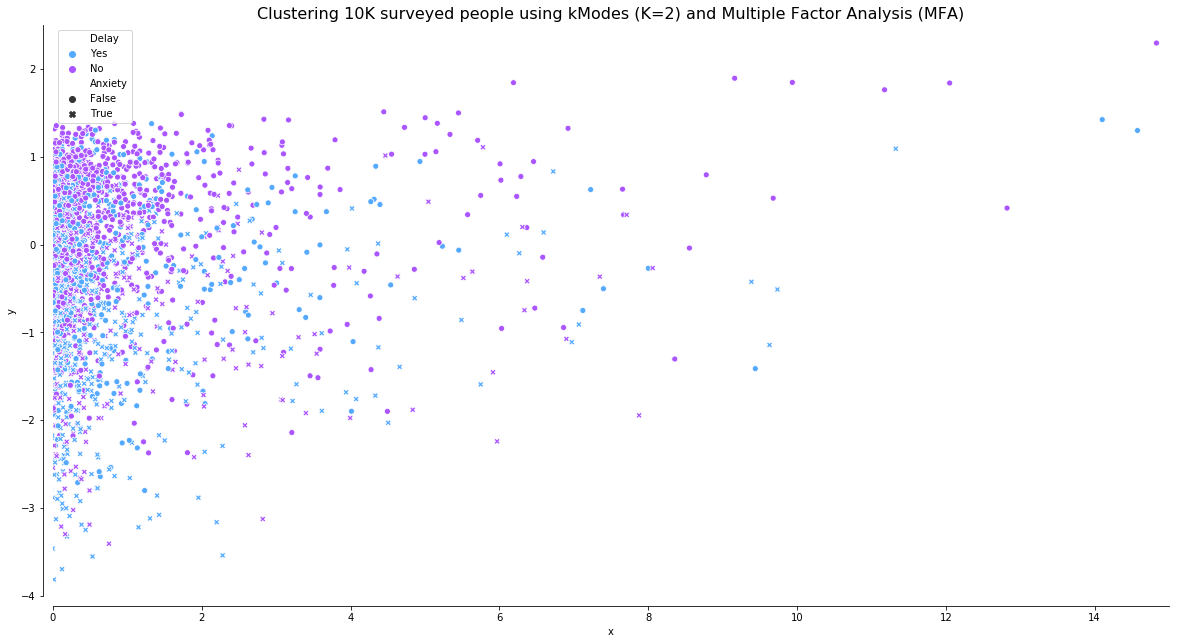

In [46]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Delay',
                    data=df_mfa, palette='cool')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.8 Dimensional relationships: Anxiety and Food sufficiency

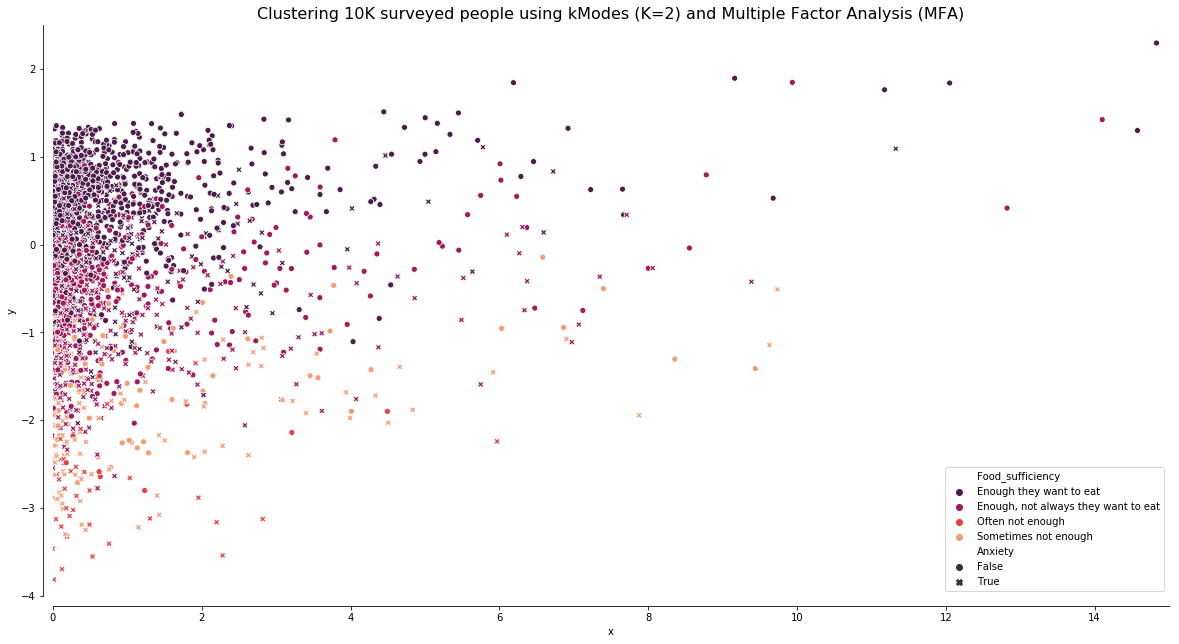

In [47]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Food_sufficiency',
                    data=df_mfa, palette='rocket')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.9 Dimensional relationships: Anxiety and Health Status

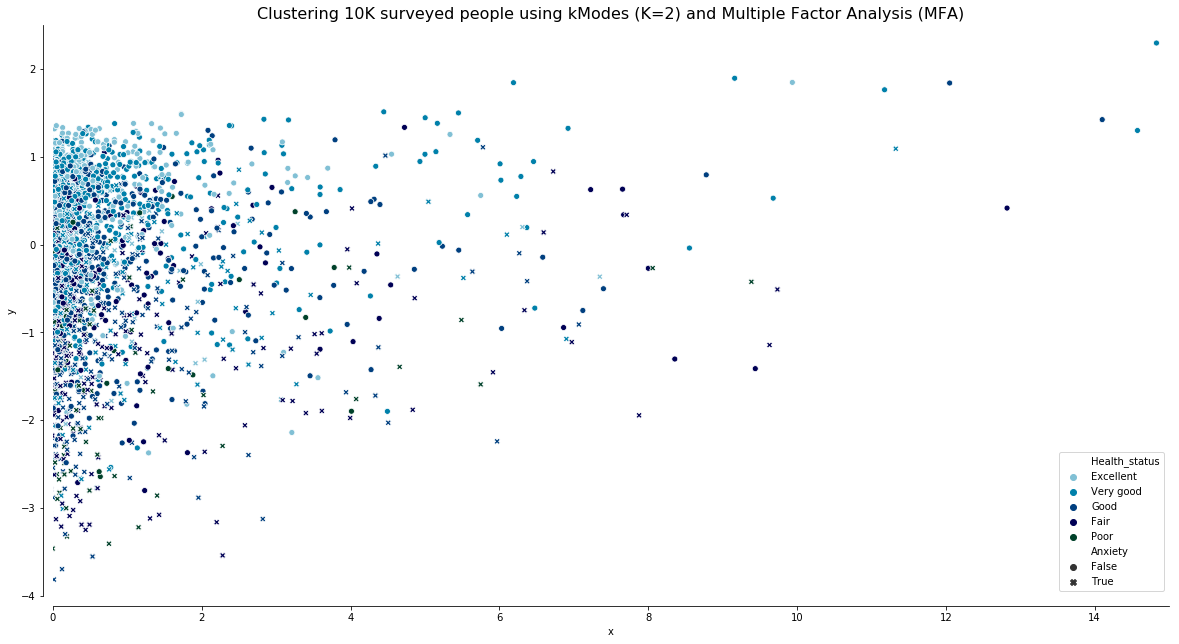

In [48]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Health_status', hue_order= ["Excellent", "Very good", 'Good', "Fair", "Poor"],
                    data=df_mfa, palette='ocean_r')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

#### 5.2.10 Dimensional relationships: Anxiety and Race

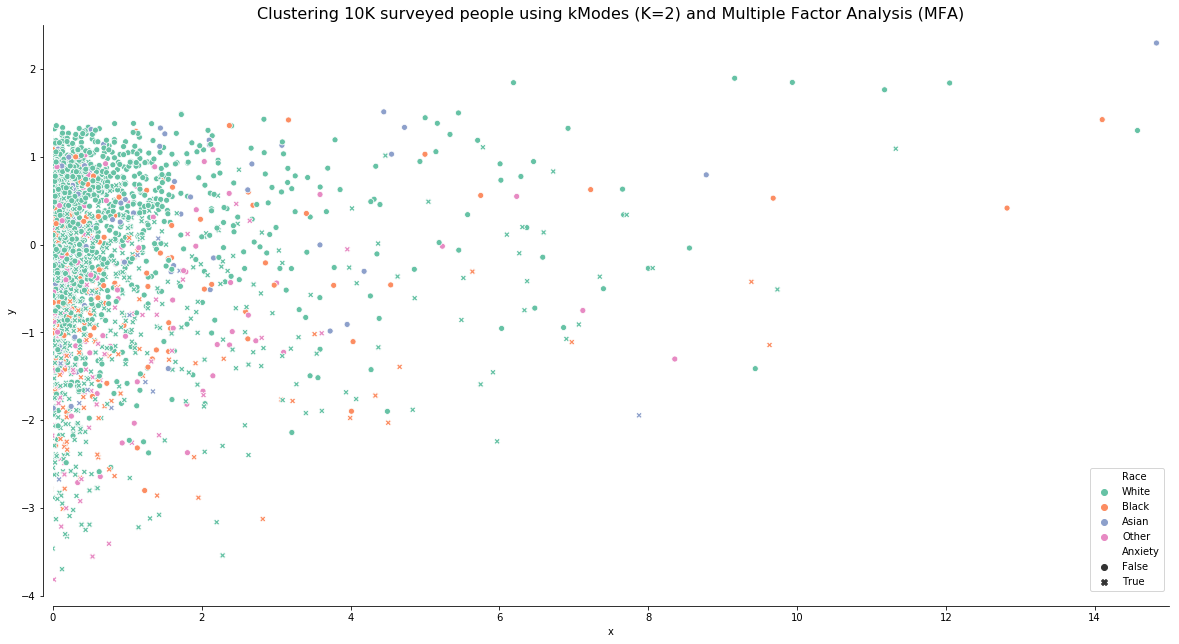

In [49]:
f, ax = plt.subplots(figsize=(20, 10.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', style='Anxiety',
                    hue='Race',
                    data=df_mfa, palette='Set2')
_ = plt.xlim([0, 15])
_ = plt.ylim([-4, 2.5])

_ = plt.title('Clustering 10K surveyed people using kModes (K=2) and Multiple Factor Analysis (MFA)', size=16)
_ = plt.show()

## 6. Analysis by state and Dendrograms

Analysis by state:

- Build feature vectors by state: check
- Use feature vectors in Dendrograms
- Select Dendrogram threshold and display clusters (k-Means)

In [50]:
Xsample1 = Xsample.drop(columns=['ABIRTH_YEAR', 'AGENDER', 'AHISPANIC', 'ARACE', 'AEDUC', 'AHHLD_NUMPER', 'AHHLD_NUMKID'])

In [51]:
Xsample1.columns

Index(['EST_ST', 'PWEIGHT', 'EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS',
       'THHLD_NUMPER', 'THHLD_NUMKID', 'THHLD_NUMADLT', 'WRKLOSS', 'EXPCTLOSS',
       'ANYWORK', 'PRIFOODSUF', 'CURFOODSUF', 'FREEFOOD', 'TSPNDFOOD',
       'TSPNDPRPD', 'HLTHSTATUS', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3',
       'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'DELAY',
       'NOTGET', 'TENURE', 'INCOME', 'AGE', 'anxiety_disorder',
       'depression_disorder'],
      dtype='object')

In [52]:
df_states = Xsample1.groupby('EST_ST').describe()

In [53]:
df_states.head()

PWEIGHT                                                                 \
         count         mean           std        min         25%          50%   
EST_ST                                                                          
1.0      139.0  4269.413966   8096.908260  74.849283  506.107725  1176.260311   
2.0      140.0   350.441719    628.948058   5.358598   66.529149   161.830598   
4.0      266.0  2177.255029   4546.586290  25.691234  409.354507  1075.296010   
5.0      143.0  1502.829598   4747.934497  49.479743  259.507017   513.969001   
6.0      717.0  4889.807808  12529.725738  15.253289  440.677486  1243.564917   

                                   EGENDER            ... INCOME         AGE  \
                75%            max   count      mean  ...    75%  max  count   
EST_ST                                                ...                      
1.0     3906.854504   46163.667431   139.0  1.676259  ...    5.0  8.0  139.0   
2.0      371.677023    5368.071894   140.0  1.600000  ...    6.0  8.0  140.0   
4.0     2165.502996   48823.284962   266.0  1.586466  ...    6.0  8.0  266.0   
5.0     1393.889405   55319.230252   143.0  1.594406  ...    6.0  8.0  143.0   
6.0     3407.523748  168181.448770   717.0  1.580195  ...    7.0  8.0  717.0   

                                                            
             mean        std   min   25%   50%   75%   max  
EST_ST                                                      
1.0     47.474820  14.888149  20.0  35.5  46.0  59.0  85.0  
2.0     45.842857  15.125029  21.0  34.0  43.5  57.0  88.0  
4.0     50.672932  15.829104  22.0  38.0  50.0  63.0  85.0  
5.0     49.384615  14.219567  18.0  39.5  48.0  60.0  80.0  
6.0     49.846583  15.546431  20.0  37.0  48.0  62.0  88.0  

[5 rows x 248 columns]

In [54]:
#df_states_anxdep = Xsample1.groupby(['EST_ST', 'anxiety_disorder', 'depression_disorder']).count().PWEIGHT
#df_states_anxdep

In [55]:
states = ['Alabama',
          'Alaska',
          'Arizona',
          'Arkansas',
          'California',
          'Colorado',
          'Connecticut',
          'Delaware',
          'District of Columbia',
          'Florida',
          'Georgia',
          'Hawaii',
          'Idaho',
          'Illinois',
          'Indiana',
          'Iowa',
          'Kansas',
          'Kentucky',
          'Louisiana',
          'Maine',
          'Maryland',
          'Massachusetts',
          'Michigan',
          'Minnesota',
          'Mississippi',
          'Missouri',
          'Montana',
          'Nebraska',
          'Nevada',
          'New Hampshire',
          'New Jersey',
          'New Mexico',
          'New York',
          'North Carolina',
          'North Dakota',
          'Ohio',
          'Oklahoma',
          'Oregon',
          'Pennsylvania',
          'Rhode Island',
          'South Carolina',
          'South Dakota',
          'Tennessee',
          'Texas',
          'Utah',
          'Vermont',
          'Virginia',
          'Washington',
          'West Virginia',
          'Wisconsin',
          'Wyoming']

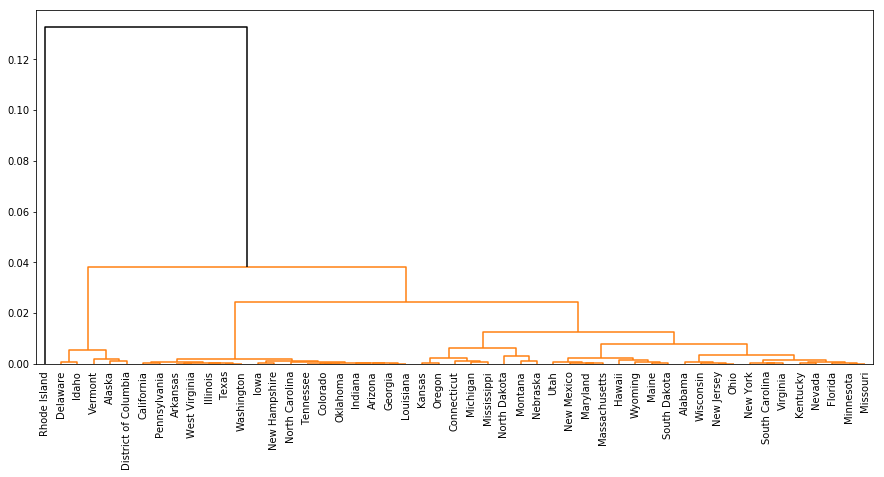

In [56]:
# Perform the necessary imports
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the linkage: mergings
mergings = linkage(df_states, method='complete', metric='cosine')

f, ax = plt.subplots(figsize=(15, 6.5))
# Plot the dendrogram, using varieties as labels
dendrogram(mergings, labels=states, leaf_rotation=90, leaf_font_size=10, above_threshold_color='k')
# _ = plt.ylim([0, 0.01])
_ = plt.show()

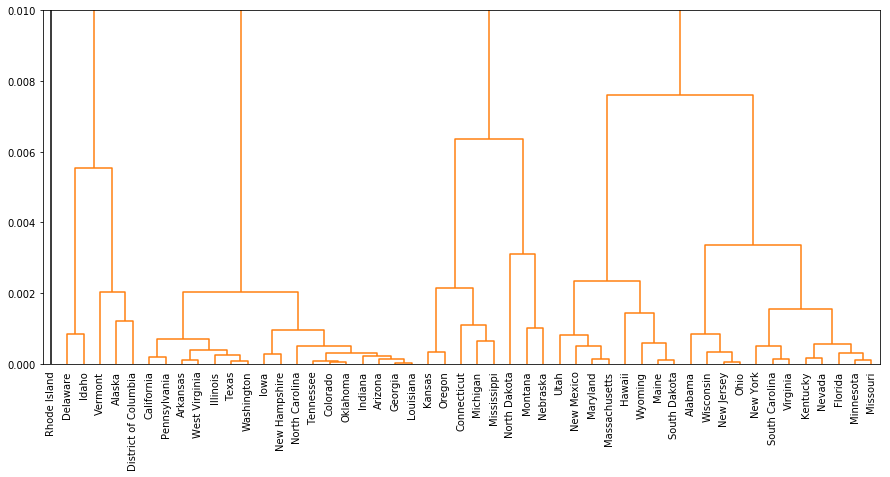

In [57]:
f, ax = plt.subplots(figsize=(15, 6.5))
# Plot the dendrogram, using varieties as labels
dendrogram(mergings, labels=states, leaf_rotation=90, leaf_font_size=10, above_threshold_color='k')
_ = plt.ylim([0, 0.01])
_ = plt.show()

In [58]:
labels = fcluster(mergings, 0.008, criterion='distance')

# Create a DataFrame with labels and varieties as columns: df
df_hier = pd.DataFrame({'labels': labels, 'varieties': states})
df_hier.groupby('labels').count()

varieties
labels           
1               5
2              17
3               8
4              20
5               1

In [59]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA #In this section, we are using numerical values, then we can use PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
points = pca.fit_transform(df_states)

In [60]:
df_pca = pd.DataFrame({'state' : df_hier.varieties[:50],
                       'cluster_id': df_hier.labels[:50], 
                       'income_mean': df_states.INCOME['mean'][:50], 
                       'x': points[:, 0], 
                       'y': points[:, 1]})

df_pca.loc[df_pca.cluster_id == 1, 'category'] = 'A'
df_pca.loc[df_pca.cluster_id == 2, 'category'] = 'B'
df_pca.loc[df_pca.cluster_id == 3, 'category'] = 'C'
df_pca.loc[df_pca.cluster_id == 4, 'category'] = 'D'
df_pca.loc[df_pca.cluster_id == 5, 'category'] = 'E'

df_pca.head()

state  cluster_id  income_mean              x            y category
0.0     Alabama         4.0          NaN    6427.923290  3917.113557        D
1.0      Alaska         1.0     3.661871  -35009.077925 -1667.347950        A
2.0     Arizona         2.0     4.692857    8695.767993  -565.385866        B
3.0    Arkansas         2.0          NaN   15133.939591 -1835.514499        B
4.0  California         2.0     4.492481  128349.202340 -3005.206535        B

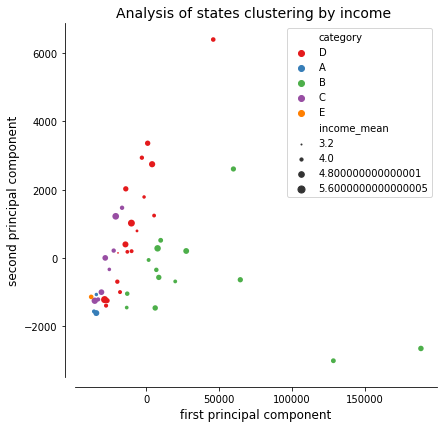

In [61]:
# Quick example
f, ax = plt.subplots(figsize=(6.5, 6.5))
_ = sns.despine(f, offset=10)
_ = sns.scatterplot(x='x', y='y', 
                    hue='category', size='income_mean',
                    data=df_pca, palette='Set1',
                    sizes=(1, 50),
                    linewidth=0)

_ = plt.xlabel('first principal component', fontsize=12)
_ = plt.ylabel('second principal component', fontsize=12)
_ = plt.title('Analysis of states clustering by income ', fontsize=14)

_ = plt.show()

In [62]:
#TO DO: compare graphs analyzing more variables